# Quantamental Trading

In this notebook, we have developed a trading Strategy by using the Fundamental data and some Quant Techniques. Notebook is divided in two parts, Strategy Formulation the Backtesting.

#### Import the relevant Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import yfinance as yf
from datetime import date
import seaborn as sb
import monthly_returns_heatmap as mrh
import fundamentalanalysis as fa
import seaborn as sb
import quantstats as qs
sb.set_style('darkgrid')
import warnings
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
warnings.filterwarnings('ignore')

# Strategy Formulation

## Analysis on Group of Companies taking latest Ratios
We will do the inter-company analysis to find the relatively undervalued companies among its peers. We will be using the Z-score method to calculate the scores of the companies and rank them accordingly.

In [2]:
key = '15d3a78098390cc68b5bf8132b213ae7'

In [3]:
"Reference from S&P Value bse Factor indices"

# Z-score testing to compare the company with its peer
def zscore2(data_frame, headline='Z-Score'):
    index = data_frame.index
    z = scipy.stats.zscore(data_frame.astype(float))
    table = pd.DataFrame(z, index=index)
    mean = table.mean(axis=1)
    table2 = pd.DataFrame(mean, index=index)
    condition1 = np.where(table2 == 0, 1, table2)
    condition2 = np.where(condition1 > 0, 1 + condition1, 1/(1 - condition1))
    final = pd.DataFrame(condition2, index=index)
    final.columns = [headline]
    return final

def calcular_indice_mensal(data):
    meses_referencia = [1, 4, 7, 10]
    mes_referencia = meses_referencia[data.month // 3] if data.month <= meses_referencia[-1] else 1
    ano = data.year if data.month <= meses_referencia[-1] else data.year + 1
    return pd.to_datetime(f"{ano}-{mes_referencia:02d}-01")

### Testes

In [4]:
# Using top Nasdaq stocks
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

# Ratios where the denominator must be high, to derive the value
ratio = ['peRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA']

f = pd.DataFrame()
for steps in range(len(tickers)):
    p = str(tickers[steps])
    data = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    table = data.T[ratio]
    f_1 = table.head(1)
    f = f.append(f_1)

f.index = tickers
# Derive the value metrics out of the algorithm "Inter Company Analysis"
inverse = 1/f

# Inverse matrix consist of the ratios that must be maximised as we have already taken the Reciprocal
inverse

,peRatio,pbRatio,evToSales,debtToEquity,debtToAssets,netDebtToEBITDA
GILD,0.039016,0.202218,0.050765,0.789674,2.333534,0.093188
MU,-0.100126,0.600719,0.046821,3.278813,4.742923,0.085714
AMAT,0.066165,0.148388,0.068857,2.497172,5.141746,1.906542
MSFT,0.03412,0.090751,0.024255,3.216731,6.280163,0.762691
AMD,-0.003547,0.346397,0.034114,19.204354,23.747893,-0.425793
CSCO,0.066499,0.218912,0.075281,5.038718,11.618894,13.154286
QCOM,0.049414,0.142804,0.061655,1.23228,3.025461,0.204849
GOOG,0.045293,0.196275,0.052479,8.958964,12.688129,37.756993
TSLA,0.015304,0.073162,0.036618,17.957399,32.448804,-0.196441
TXN,0.040495,0.09035,0.025115,1.505333,2.885641,0.406267


Function to calculate the Z-score of the above Dataframe. So, that we can have normalized data and can compare the ratios and do the ranking.

In [5]:
# Calling the function and calculating the relative score of each company
z = zscore2(inverse)
z

,Z-Score
GILD,0.753015
MU,0.740383
AMAT,0.964086
MSFT,0.687200
AMD,1.468417
CSCO,1.448593
QCOM,0.801546
GOOG,1.754668
TSLA,1.445974
TXN,0.645975


Comparing the past year performance of each company. We will be using some critical ratios and then will be quantifying so as to convert them into a score.

In [6]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare']

# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']


tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

# F-Score and G-Score analysis to compare the companies with its Past Quarter Performances "Intra Companies Analysis"

M = pd.DataFrame()
for steps in range(len(tickers)):
    p = str(tickers[steps])
    data = fa.key_metrics(
        ticker=p, api_key=key, period="quarter")
    gh = data.T
    gh = gh.iloc[:, 1:]
    gh = gh.loc[::-1]
    gh = gh.loc['2019-12':]
    change = gh.pct_change()
    test = change[f_score_ratio_max].dropna()
    test1 = change[f_score_ratio_min].dropna()
    test2 = change[g_score_ratio_max].dropna()
    g = np.where(test > 0, 1, -1)

    # Conditions to Score the past performance and create a ranking table for every set
    g1 = np.where(test < 0, 1, -1)
    g2 = np.where(test2 > 0, 1, -1)
    array = np.array([g.sum(), g1.sum(), g2.sum()])
    df = pd.DataFrame(array)
    df = df.T
    M = M.append(df)
    
M.index = tickers
M.columns = columns

# Now, as we already have the scores, we take the z-score of the final DataFrame,
# in order to compare the scores with each other

# Comparing the Score table along with its peers
ZS = scipy.stats.zscore(M)
ZS = pd.DataFrame(ZS)
ZS.index = M.index
ZS.columns = M.columns
v = pd.concat([ZS, z], axis=1)
Score_table = pd.DataFrame({"Score": v.sum(axis=1)})
y = Score_table.sort_values(by='Score', ascending=False)

# Final DataFrame having the Score of each company
y

,Score
GOOG,2.566864
TSLA,2.407785
CSCO,1.961559
ATVI,1.892584
TXN,1.757400
MSFT,1.649011
AMAT,1.477052
PCAR,1.199975
AMD,1.083693
QCOM,0.865666


Above Dataframe has final score and it represents the relatively undervalued companies, which are also fundamentally strong.

# Backtesting the strategy 
Selecting the companies at start of the year and then taking the positions in them for the year long and 
rebalancing the companies at start of next year.

In [249]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

In [49]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2017','2018', '2019', '2020']

for steps1 in range(len(year)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        table = data.T[ratio]
        table = table.loc[year[steps1]]
        Full_table = Full_table.append(table)

Full_table.head()

,peRatio,priceToSalesRatio,pbRatio,evToSales,debtToEquity,evToFreeCashFlow,debtToAssets,netDebtToEBITDA
2017,20.231953,3.586528,4.580446,4.580667,1.640837,10.575476,0.477242,1.628946
2017,6.841291,1.713184,1.869681,2.010694,0.599055,11.951252,0.315684,0.625556
2017,17.466715,4.126071,6.415734,4.146296,0.567333,18.466513,0.273135,0.067804
2017,25.180710,5.935873,7.375360,6.808925,1.190624,19.518860,0.357524,2.299657
2017,227.594419,1.836472,16.017283,1.875879,2.283142,-222.145778,0.394068,0.603448


In [9]:
pd.__version__

'1.3.5'

In [10]:
#!pip uninstall pandas --yes
#!pip install pandas==1.3.5

In [63]:
rank = pd.DataFrame()

for steps in range(len(Full_table.index)):
    y = Full_table.loc[Full_table.index[steps]]
    t_inv = 1/y
    bv = zscore2(t_inv)
    #bv = bv.T
    #bv.index = [year[steps]]
    #bv.columns = tickers
    
    rank = rank.append(bv)

rank

,Z-Score
2017,1.009932
2017,2.056281
2017,1.244755
2017,0.732541
2017,0.903451
...,...
2020,0.663530
2020,1.867815
2020,0.837222
2020,0.807834


In [51]:
name = pd.DataFrame(tickers)
concated = pd.concat([name]*len(year), axis=0)
concated.index = Full_table.index
concated.columns = ['Company']

lista_z_score = []
for i in year:
    lista_z_score += list(rank.loc[i])

lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
rank = pd.concat([concated, lista_z_score], axis=1)

rank.head()

,Company,Z-Score
2017,GILD,1.009932
2017,MU,2.056281
2017,AMAT,1.244755
2017,MSFT,0.732541
2017,AMD,0.903451


Now doing the Intra-Company analysis, comparing the past performances of the companies to derive out fundamentally strong companies.

In [253]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]

sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']


# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]

sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [254]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
Final_yr_wise = Final_yr_wise.loc[year]
Final_yr_wise.head(4)

,F-Score-Max,F-Score-Min,G-Score-Max,Company
2017,-2,1,2,GILD
2017,-2,-1,0,MU
2017,2,-3,4,AMAT
2017,4,-1,4,MSFT


In [255]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company

rank = rank.loc[year[0]:]
vc.head()

,Cumulative-F&G-Score,Company
2017,1.142199,GILD
2017,0.672095,MU
2017,1.239184,AMAT
2017,1.915829,MSFT
2017,0.601402,AMD


In [256]:
# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)

,index,Cumulative-F&G-Score,Company,key
0,2017,1.142199,GILD,2017_GILD
1,2017,0.672095,MU,2017_MU
2,2017,1.239184,AMAT,2017_AMAT


In [257]:
rank_new = rank.reset_index()
rank_new['key'] = rank_new['index']+str('_')+rank_new['Company']
df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
dataframe_final.head(4)

,Company_y,Cumulative-Score
index_x,,
2017,GILD,2.152131
2017,MU,2.728375
2017,AMAT,2.483939
2017,MSFT,2.648369


In [258]:
stock = yf.download(tickers=tickers, start='2016-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  14 of 14 completed


In [271]:
stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()
returns = returns.loc[year[0]:year[-1]]
returns.head()

,GILD,MU,AMAT,MSFT,AMD,CSCO,QCOM,GOOG,TSLA,TXN,INTC,ATVI,PEP,PCAR
Date,,,,,,,,,,,,,,
2017-01-01,0.061357,-0.085538,0.113542,0.016545,0.011730,0.032352,0.015164,0.040393,0.099909,0.053365,-0.008124,-0.180521,0.178951,0.035220
2017-02-01,0.057518,0.394407,0.122358,0.112630,-0.027191,0.033158,-0.016839,-0.010364,-0.027789,-0.007428,0.063596,0.057084,-0.007701,0.014297
2017-03-01,0.073992,0.006224,0.104808,-0.011118,-0.036322,0.007714,-0.003591,0.029384,0.232935,0.005837,0.013408,0.015227,0.113245,0.051423
2017-04-01,0.043959,-0.085911,0.047934,0.007988,0.009276,0.092097,0.002218,0.039478,-0.042561,-0.006994,0.012694,-0.062783,0.128530,-0.017130
2017-05-01,0.129771,-0.158647,0.121148,-0.074552,-0.053392,0.065014,-0.001107,0.020158,0.112035,-0.056496,0.031691,0.065687,0.085777,0.041803


Taking the positions in the top 6 Companies, with equally weighted rule.

In [272]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in set(list(dataframe_final.index)):
    sorted_table = (dataframe_final.loc[steps]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)

    returns_selection = returns.loc[steps]
    selected_returns = returns_selection[array]
    
    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)
    df2 = df2.append(frame1)

In [273]:
comp_index = np.repeat(year, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

In [274]:
list_comp = pd.DataFrame()
for steps in range(len(year)):
    f = df2.loc[year[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = year
list_comp

,0,1,2,3,4,5
2017,GILD,MU,INTC,PCAR,AMD,GOOG
2018,AMAT,INTC,AMD,CSCO,MU,MSFT
2019,PCAR,MU,MSFT,AMAT,GILD,GOOG
2020,ATVI,MU,MSFT,GILD,PCAR,GOOG


Following DataFrame shows the list of the companies in which we Invested Year-Wise.

Weights- Equally Weighted.

In [275]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

Downloading the Benchmark 'NASDAQ' and Comparing the performance with it.

In [276]:
benchmark = yf.download(tickers='NDAQ', start='2016-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [277]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()

In [278]:
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')

In [279]:
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns = benchmark_returns.loc[year[0]:year[-1]]

In [280]:
frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.columns = ['strategy', 'nasdaq']
frame_final.index = frame_final.index.to_timestamp()
frame_final

,strategy,nasdaq
Date,,
2017-01-01,0.030253,0.050953
2017-02-01,0.115141,0.008081
2017-03-01,0.042452,-0.023344
2017-04-01,0.006053,-0.008351
2017-05-01,0.013280,-0.017715
2017-06-01,-0.014882,0.056763
2017-07-01,0.058938,0.040285
2017-08-01,0.017496,0.013581
2017-09-01,0.040320,0.029053


## Comparing the Returns of the Strategy with the NASDAQ
Import `teersheet` module to get full performance metric.

In [269]:
import quantstats as qs

Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-01-01   2017-01-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          97.77%       210.13%
CAGR﹪                     12.77%       22.07%

Sharpe                     4.48         6.59
Prob. Sharpe Ratio         96.66%       99.62%
Smart Sharpe               3.41         5.01
Sortino                    7.29         12.22
Smart Sortino              5.54         9.29
Sortino/√2                 5.15         8.64
Smart Sortino/√2           3.92         6.57
Omega                      2.9          2.9

Max Drawdown               -18.47%      -16.21%
Longest DD Days            243          124
Volatility (ann.)          89.21%       98.35%
R^2                        0.24         0.24
Information Ratio          0.17         0.

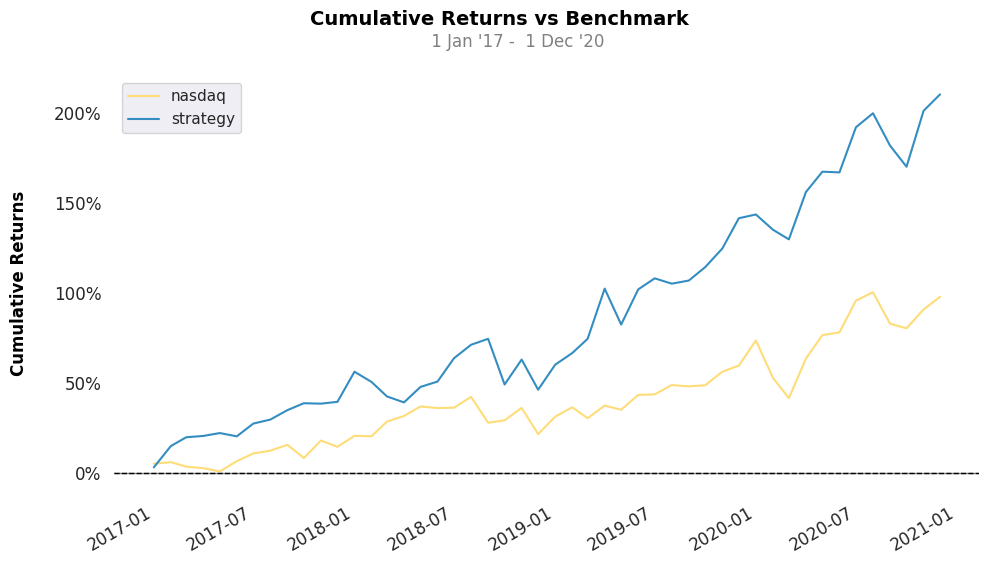

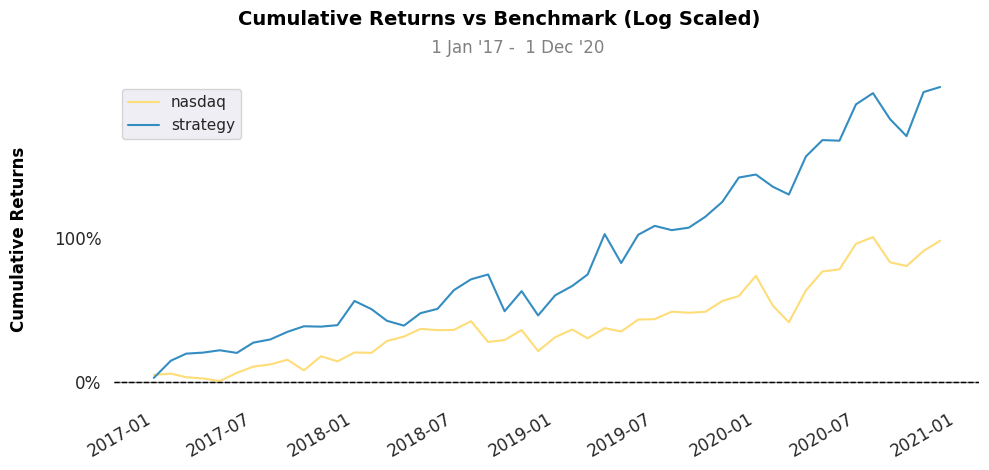

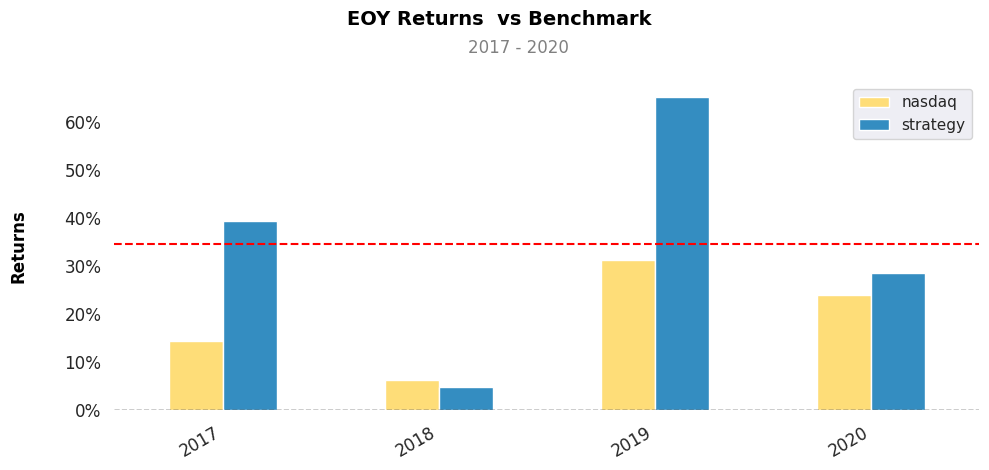

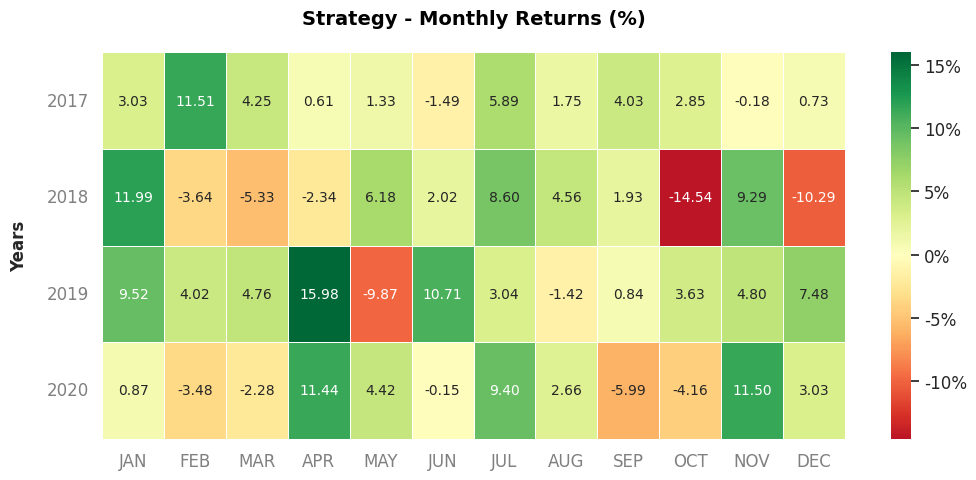

In [281]:
print("\033[1mPerformance Metrics\033[0m\n")
qs.reports.metrics(frame_final['strategy'],frame_final['nasdaq'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.log_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.yearly_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.monthly_heatmap(frame_final['strategy'],frame_final['nasdaq'])

# Replicando estudo sem nenhuma alteração para as 20 principais ações do Ibovespa 

In [29]:
tickers = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

len(tickers)

20

In [30]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

for steps1 in range(len(year)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        table = data.T[ratio]
        table = table.loc[year[steps1]]
        Full_table = Full_table.append(table)

Full_table

,peRatio,priceToSalesRatio,pbRatio,evToSales,debtToEquity,evToFreeCashFlow,debtToAssets,netDebtToEBITDA
2011,4.849135,1.881208,1.427941,2.236777,0.315332,15.668858,0.190370,0.603528
2011,7.480568,1.031536,0.855995,1.469256,0.471610,-64.457760,0.259626,1.645625
2011,11.126058,2.072692,2.082083,2.190671,1.965148,-14.380404,0.177605,0.116460
2011,5.349839,1.129452,0.991288,0.643243,1.158981,-0.795088,0.094953,-0.397874
2011,18.232143,10.036799,0.993552,10.036799,0.000000,13.007715,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2020,-7.371343,2.592999,10.921654,4.932327,10.798336,18.262323,0.767103,4.892366
2020,20.979705,4.988432,3.015127,5.895143,0.804916,14.771019,0.373308,1.369121
2020,17.417276,0.949303,1.347797,1.263752,0.596063,12.029619,0.291410,1.647307
2020,13.661434,0.232489,1.565817,0.426163,1.794925,6.488485,0.439624,2.469496


In [31]:
rank = pd.DataFrame()

for steps in range(len(year)):
    y = Full_table.loc[year[steps]]
    t_inv = 1/y
    bv = zscore2(t_inv)
    bv = bv.T
    bv.index = [year[steps]]
    bv.columns = tickers
    
    rank = rank.append(bv)

In [32]:
name = pd.DataFrame(tickers)
concated = pd.concat([name]*len(year), axis=0)
concated.index = Full_table.index
concated.columns = ['Company']

lista_z_score = []
for i in year:
    lista_z_score += list(rank.loc[i])

lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
rank = pd.concat([concated, lista_z_score], axis=1)

rank

,Company,Z-Score
2011,VALE3.SA,1.198901
2011,PETR4.SA,1.282748
2011,ITUB4.SA,0.797951
2011,BBDC4.SA,1.099540
2011,B3SA3.SA,0.751429
...,...,...
2020,SUZB3.SA,0.525550
2020,PRIO3.SA,0.767735
2020,GGBR4.SA,1.164545
2020,JBSS3.SA,1.979066


Now doing the Intra-Company analysis, comparing the past performances of the companies to derive out fundamentally strong companies.

In [33]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]
condition
sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']
sum_score

# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]
condition2
sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']
sum_score2

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [34]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)

print(rank.loc[year[0:]].head())
Final_yr_wise.loc[year[0:]].head()

       Company   Z-Score
2011  VALE3.SA  1.198901
2011  PETR4.SA  1.282748
2011  ITUB4.SA  0.797951
2011  BBDC4.SA  1.099540
2011  B3SA3.SA  0.751429


,F-Score-Max,F-Score-Min,G-Score-Max,Company
2011,4,1,2,VALE3.SA
2011,2,1,-4,PETR4.SA
2011,2,1,-4,ITUB4.SA
2011,-2,-1,2,BBDC4.SA
2011,-4,-3,2,B3SA3.SA


In [35]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company

rank = rank.loc[year[0]:]

# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)
rank_new = rank.reset_index()
rank_new['key'] = rank_new['index']+str('_')+rank_new['Company']
df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
dataframe_final.head(4)

,Company_y,Cumulative-Score
index_x,,
2011,VALE3.SA,3.626999
2012,VALE3.SA,1.590085
2013,VALE3.SA,2.420880
2014,VALE3.SA,2.408019


In [36]:
stock = yf.download(tickers=tickers, start='2011-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()

[*********************100%***********************]  20 of 20 completed


Assumindo as posições das 6 maiores Empresas, com peso igual

In [37]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in range(len(year)):
    sorted_table = (dataframe_final.loc[year[steps]]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)
    returns_selection = returns.loc[year[steps]]
    selected_returns = returns_selection[array]

    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)
    df2 = df2.append(frame1)

In [38]:
comp_index = np.repeat(year, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

list_comp = pd.DataFrame()
for steps in range(len(year)):
    f = df2.loc[year[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = year

list_comp

,0,1,2,3,4,5
2011,VALE3.SA,ELET3.SA,JBSS3.SA,EQTL3.SA,PETR4.SA,BBAS3.SA
2012,CSAN3.SA,PRIO3.SA,ABEV3.SA,RENT3.SA,WEGE3.SA,ITSA4.SA
2013,ABEV3.SA,ELET3.SA,GGBR4.SA,LREN3.SA,JBSS3.SA,RENT3.SA
2014,JBSS3.SA,ITSA4.SA,RADL3.SA,ELET3.SA,ITUB4.SA,EQTL3.SA
2015,EQTL3.SA,PRIO3.SA,LREN3.SA,RADL3.SA,CSAN3.SA,JBSS3.SA
2016,PRIO3.SA,CSAN3.SA,SUZB3.SA,PETR4.SA,WEGE3.SA,JBSS3.SA
2017,JBSS3.SA,PETR4.SA,VALE3.SA,ABEV3.SA,SUZB3.SA,EQTL3.SA
2018,VALE3.SA,ABEV3.SA,CSAN3.SA,ITSA4.SA,PRIO3.SA,ELET3.SA
2019,BBAS3.SA,JBSS3.SA,WEGE3.SA,ELET3.SA,EQTL3.SA,B3SA3.SA
2020,JBSS3.SA,BBAS3.SA,WEGE3.SA,GGBR4.SA,RENT3.SA,VALE3.SA


Following DataFrame shows the list of the companies in which we Invested Year-Wise.

Weights- Equally Weighted.

In [39]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

Downloading the Benchmark 'IBOVESPA' and Comparing the performance with it.

In [40]:
benchmark = yf.download(tickers='^BVSP', start='2011-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [41]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
benchmark_returns = benchmark.pct_change().dropna()

frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.index = frame_final.index.to_timestamp()
frame_final.columns = ['strategy', 'ibovespa']
frame_final

,strategy,ibovespa
Date,,
2011-02-01,0.007671,0.012137
2011-03-01,0.008670,0.017868
2011-04-01,-0.026741,-0.035779
2011-05-01,-0.136440,-0.022878
2011-06-01,-0.020166,-0.034293
...,...,...
2020-08-01,-0.000842,-0.034427
2020-09-01,-0.030777,-0.047963
2020-10-01,0.035161,-0.006881


## Comparing the Returns of the Strategy with the IBOVESPA
Import `teersheet` module to get full performance metric.

Performance Metrics
                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2011-02-01   2011-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          79.21%       117.09%
CAGR﹪                     4.18%        5.59%

Sharpe                     1.72         2.04
Prob. Sharpe Ratio         87.21%       91.62%
Smart Sharpe               1.36         1.61
Sortino                    2.56         3.16
Smart Sortino              2.03         2.51
Sortino/√2                 1.81         2.23
Smart Sortino/√2           1.44         1.77
Omega                      1.42         1.42

Max Drawdown               -41.09%      -54.83%
Longest DD Days            2284         1158
Volatility (ann.)          104.74%      111.22%
R^2                        0.78         0.78
Information Ratio          0.06         0.

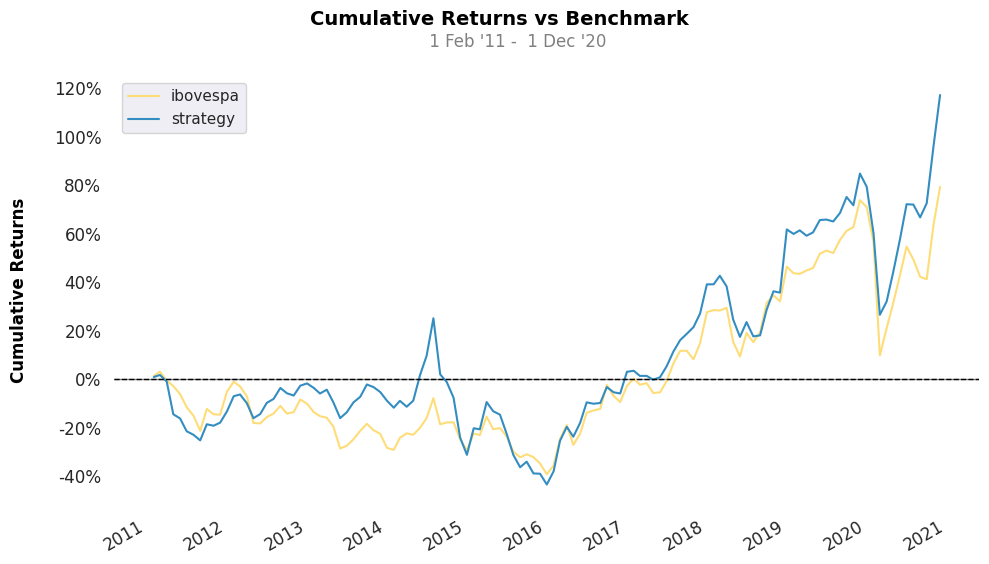

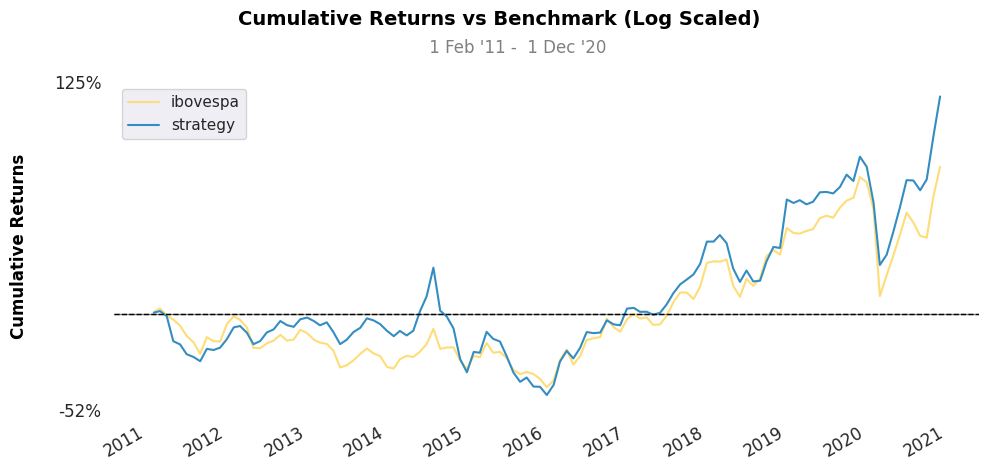

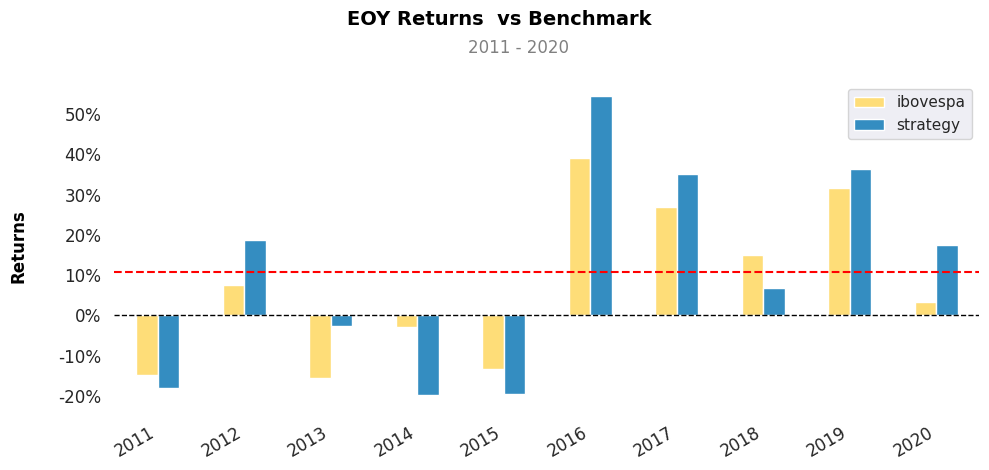

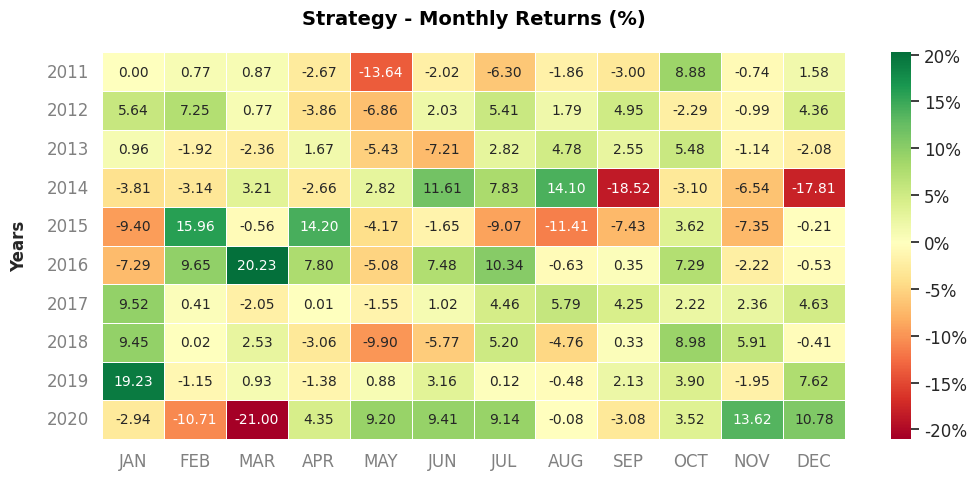

In [42]:
print("\033[1mPerformance Metrics\033[0m")
qs.reports.metrics(frame_final['strategy'],frame_final['ibovespa'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['strategy'],frame_final['ibovespa'])
qs.plots.log_returns(frame_final['strategy'],frame_final['ibovespa'])
qs.plots.yearly_returns(frame_final['strategy'],frame_final['ibovespa'])
qs.plots.monthly_heatmap(frame_final['strategy'],frame_final['ibovespa'])

## Criando funções para deixarem as análises mais otimizadas

In [43]:
def Analise_Fund(tickers,ratio,year):
    # WRT to cash, income and book value
    
    # Ratios to derive out the value factor
    Full_table = pd.DataFrame()
    
    for steps1 in range(len(year)):
        for steps2 in range(len(tickers)):
            p = str(tickers[steps2])
            data = fa.key_metrics(
                ticker=p, api_key=key, period='annual')
            table = data.T[ratio]
            table = table.loc[year[steps1]]
            Full_table = Full_table.append(table)
    
    rank = pd.DataFrame()

    for steps in range(len(year)):
        y = Full_table.loc[year[steps]]
        t_inv = 1/y
        bv = zscore2(t_inv)
        bv = bv.T
        bv.index = [year[steps]]
        bv.columns = tickers

        rank = rank.append(bv)
    
    name = pd.DataFrame(tickers)
    concated = pd.concat([name]*len(year), axis=0)
    concated.index = Full_table.index
    concated.columns = ['Company']

    lista_z_score = []
    for i in year:
        lista_z_score += list(rank.loc[i])

    lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
    rank = pd.concat([concated, lista_z_score], axis=1)

    return rank

In [44]:
def Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year):

    percent_fscore_max = pd.DataFrame()
    percent_fscore_min = pd.DataFrame()
    percent_gscore_max = pd.DataFrame()
    vc = pd.DataFrame()
    
    for steps in range(len(tickers)):
        # Fscore-Max analysis
        p = str(tickers[steps])
        data3 = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        tranpose = data3.T[f_score_ratio_max].fillna(0)
        reverse = tranpose.loc[::-1]
        change = reverse.pct_change()
        change = change.assign(Company=p)
        percent_fscore_max = percent_fscore_max.append(change)

        # Fscore-Min analysis
        data4 = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        tranpose1 = data4.T[f_score_ratio_min].fillna(0)
        reverse1 = tranpose1.loc[::-1]
        change1 = reverse1.pct_change()
        change1 = change1.assign(Company=p)
        percent_fscore_min = percent_fscore_min.append(change1)

        # Gscore-Max analysis
        data5 = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        tranpose2 = data5.T[g_score_ratio_max].fillna(0)
        reverse2 = tranpose2.loc[::-1]
        change2 = reverse2.pct_change()
        change2 = change2.assign(Company=p)
        percent_gscore_max = percent_gscore_max.append(change2)

    # Condition to quantify the performance
    condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
    condition = pd.DataFrame(condition)
    condition.index = percent_fscore_max.index
    condition.columns = percent_fscore_max.columns[:-1]
    
    sum_score = condition.sum(axis=1)
    sum_score = pd.DataFrame(sum_score)
    sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
    sum_score.columns = ['F-Score-Max','Company']

    # Condition to quantify the performance
    condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
    condition2 = pd.DataFrame(condition2)
    condition2.index = percent_fscore_min.index
    condition2.columns = percent_fscore_min.columns[:-1]

    sum_score2 = condition2.sum(axis=1)
    sum_score2 = pd.DataFrame(sum_score2)
    sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
    sum_score2.columns = ['F-Score-Min','Company']

    # Condition to quantify the performance
    condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
    condition3 = pd.DataFrame(condition3)
    condition3.index = percent_gscore_max.index
    condition3.columns = percent_gscore_max.columns[:-1]
    sum_score3 = condition3.sum(axis=1)
    sum_score3 = pd.DataFrame(sum_score3)
    sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
    sum_score3.columns = ['G-Score-Max','Company']
    
    Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
    Final_yr_wise = Final_yr_wise.loc[year]
    company = pd.DataFrame(Final_yr_wise['Company'])
    
    vc['Company'] = company
    vc['Cumulative-F&G-Score'] = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]])

    return vc

In [45]:
def Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,qtd = 6):
    # Now Joing the two Dataframes and getting a cumulative score of each company for each year
    df = pd.DataFrame()
    
    rank = Analise_Fund(tickers,ratio,year)
    vc = Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year)
    
    vc_new = vc.reset_index()
    vc_new['key'] = vc_new['index'] + str('_') + vc_new['Company']
    
    rank_new = rank.reset_index()
    rank_new['key'] = rank_new['index'] + str('_') + rank_new['Company']
    df = vc_new.merge(rank_new, on='key')
    df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
    df.index = df['index_x']
    
    dataframe = df.drop(labels='index_x', axis=1)
    dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
        dataframe['Z-Score'].values
    dataframe_final = dataframe.drop(
        labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
    
    # Ações a serem investidas pela estratégia
    acoes = pd.DataFrame()

    for steps in range(len(year)):
        sorted_table = (dataframe_final.loc[year[steps]]).sort_values(
            by='Cumulative-Score', ascending=False)
        selection = sorted_table[['Company_y']].head(qtd)
        array = np.array(selection['Company_y'])
        frame = pd.DataFrame(array)
        acoes = acoes.append(frame)
    
    comp_index = np.repeat(year, qtd)
    acoes.index = comp_index
    acoes.columns = ['Companies-Invested']

    list_comp = pd.DataFrame()
    for steps in range(len(year)):
        f = acoes.loc[year[steps]]['Companies-Invested'].T
        mk = np.array(f)
        l = pd.DataFrame(mk).T
        list_comp = list_comp.append(l)

    list_comp.index = year

    return list_comp

In [46]:
def comparar_estrategia(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,ticker_benchmark,name_benchmark,qtd = 6):
    # retorno da estratégia
    estrategia = Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year)
    
    df = pd.DataFrame()
    inicio = year[0] + '-01-01'
    final = year[-1] + '-12-31'
    
    stock = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Close']]

    stock.index = pd.to_datetime(stock.index)
    stock = (stock.T.drop_duplicates().T).dropna()
    stock.columns = tickers
    returns = stock.pct_change().dropna()
    
    for steps in range(len(year)):
        array = estrategia.loc[year[steps]]
        returns_selection = returns.loc[year[steps]]
        selected_returns = returns_selection[array]

        # Portfólio com pesos iguais
        weight = np.repeat(1/qtd, qtd)
        series = (selected_returns*weight).sum(axis=1)
        frame = pd.DataFrame(series)
        df = df.append(frame)
        
    df.columns = ['Returns']
    df.index = pd.to_datetime(df.index).to_period('M')
    
    # retorno do benchmark
    benchmark = yf.download(tickers=ticker_benchmark, start=inicio,
                        end=final, interval='1mo')[['Close']]
    benchmark = (benchmark.T.drop_duplicates().T).dropna()
    benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
    benchmark_returns = benchmark.pct_change().dropna()
    
    # comparando a estratégia com o benchmark
    frame_final = pd.concat([df, benchmark_returns], axis=1)
    frame_final.columns = ['Strategy', name_benchmark]
    frame_final.index = frame_final.index.to_timestamp()
    
    print("\033[1mPerformance Metrics\033[0m\n")
    qs.reports.metrics(frame_final['Strategy'],frame_final[name_benchmark],mode='full')

    print("\n\033[1mStrategy Visualization\033[0m\n")
    qs.plots.returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.log_returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.yearly_returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.monthly_heatmap(frame_final['Strategy'],frame_final[name_benchmark])
    

### Resultados usando as funções criadas

In [47]:
tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

tickers_us = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year_us = ['2017','2018', '2019', '2020']

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_us ='NDAQ'
benchmark_br = '^BVSP'

In [48]:
Analise_Fund(tickers_br,ratio,year_br)

,Company,Z-Score
2011,VALE3.SA,1.198901
2011,PETR4.SA,1.282748
2011,ITUB4.SA,0.797951
2011,BBDC4.SA,1.099540
2011,B3SA3.SA,0.751429
...,...,...
2020,SUZB3.SA,0.525550
2020,PRIO3.SA,0.767735
2020,GGBR4.SA,1.164545
2020,JBSS3.SA,1.979066


In [49]:
Analise_Quant(tickers_br,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br)

,Company,Cumulative-F&G-Score
2011,VALE3.SA,2.416568
2011,PETR4.SA,1.504247
2011,ITUB4.SA,1.504247
2011,BBDC4.SA,1.066374
2011,B3SA3.SA,0.604897
...,...,...
2020,SUZB3.SA,1.299020
2020,PRIO3.SA,0.604897
2020,GGBR4.SA,1.176471
2020,JBSS3.SA,0.878077


In [50]:
Estrategia_Quantamental(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,qtd = 8)

,0,1,2,3,4,5,6,7
2011,VALE3.SA,ELET3.SA,JBSS3.SA,EQTL3.SA,PETR4.SA,BBAS3.SA,CSAN3.SA,BBDC3.SA
2012,CSAN3.SA,PRIO3.SA,ABEV3.SA,RENT3.SA,WEGE3.SA,ITSA4.SA,RADL3.SA,JBSS3.SA
2013,ABEV3.SA,ELET3.SA,GGBR4.SA,LREN3.SA,JBSS3.SA,RENT3.SA,VALE3.SA,WEGE3.SA
2014,JBSS3.SA,ITSA4.SA,RADL3.SA,ELET3.SA,ITUB4.SA,VALE3.SA,EQTL3.SA,BBDC3.SA
2015,EQTL3.SA,PRIO3.SA,LREN3.SA,RADL3.SA,CSAN3.SA,JBSS3.SA,PETR4.SA,GGBR4.SA
2016,PRIO3.SA,CSAN3.SA,SUZB3.SA,PETR4.SA,WEGE3.SA,JBSS3.SA,RADL3.SA,ITSA4.SA
2017,JBSS3.SA,PETR4.SA,VALE3.SA,ABEV3.SA,SUZB3.SA,EQTL3.SA,RADL3.SA,ITSA4.SA
2018,VALE3.SA,ABEV3.SA,CSAN3.SA,ITSA4.SA,PRIO3.SA,JBSS3.SA,ELET3.SA,ITUB4.SA
2019,BBAS3.SA,JBSS3.SA,WEGE3.SA,ELET3.SA,EQTL3.SA,B3SA3.SA,ITSA4.SA,CSAN3.SA
2020,JBSS3.SA,BBAS3.SA,WEGE3.SA,GGBR4.SA,RENT3.SA,VALE3.SA,ITSA4.SA,ITUB4.SA


### Comparando com o Nasdaq usando as funções

[*********************100%***********************]  14 of 14 completed
[*********************100%***********************]  1 of 1 completed
Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-02-01   2017-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          88.18%       201.02%
CAGR﹪                     12.06%       21.96%

Sharpe                     4.24         6.5
Prob. Sharpe Ratio         95.81%       99.55%
Smart Sharpe               3.2          4.9
Sortino                    6.87         12.04
Smart Sortino              5.18         9.08
Sortino/√2                 4.86         8.52
Smart Sortino/√2           3.66         6.42
Omega                      2.85         2.85

Max Drawdown               -18.47%      -16.21%
Longest DD Days            243         

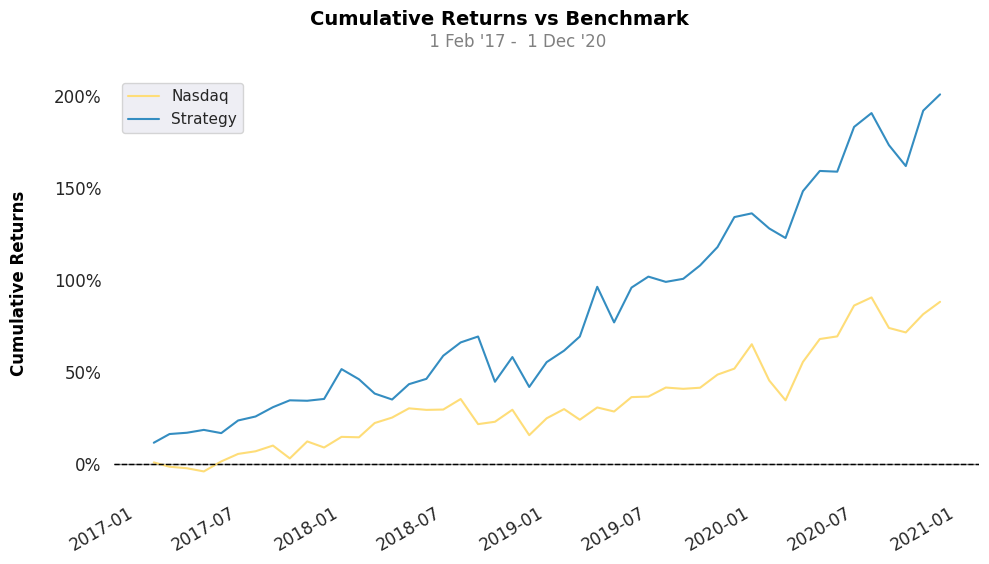

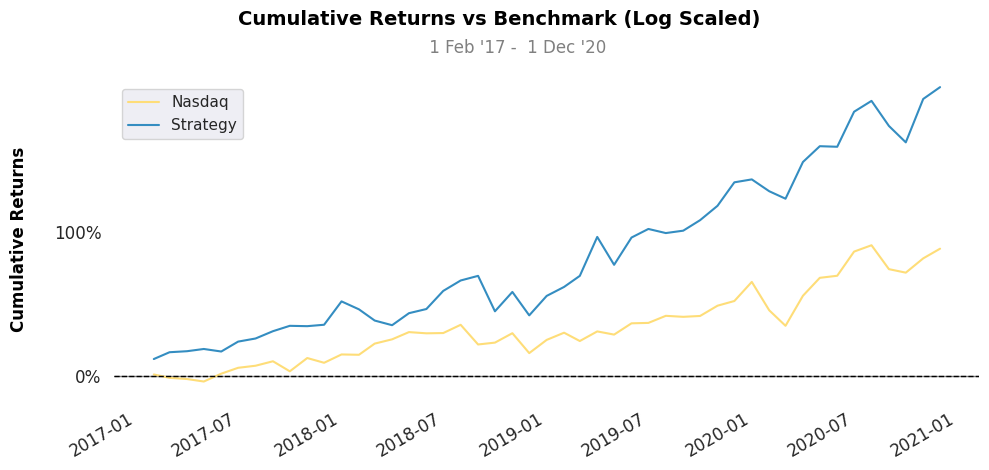

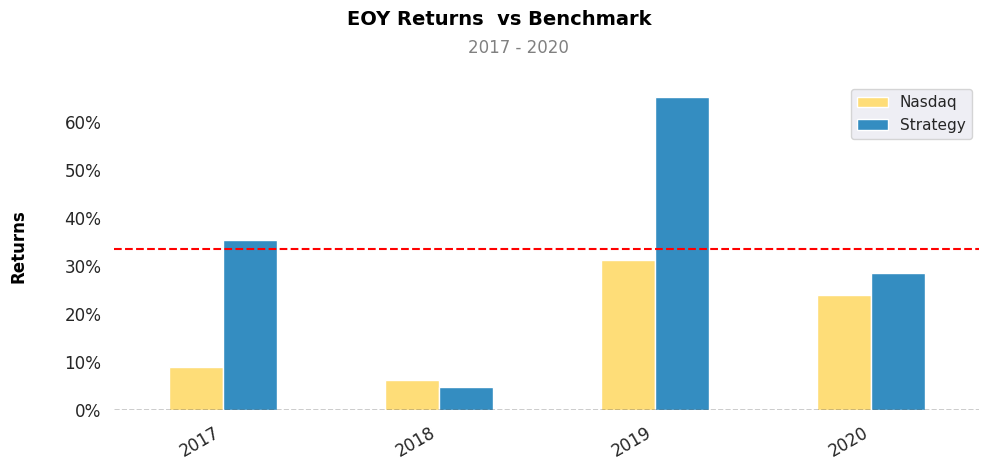

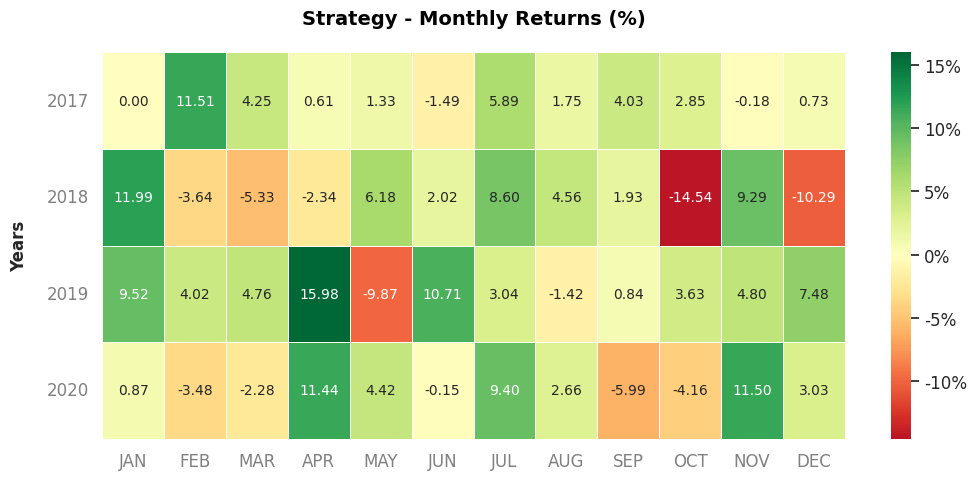

In [51]:
tickers_us = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year_us = ['2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_us ='NDAQ'
name_benchmark_us = 'Nasdaq'

comparar_estrategia(tickers_us,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_us,benchmark_us,name_benchmark_us,qtd = 6)

### Comparando com o Ibovespa usando as funções

[*********************100%***********************]  20 of 20 completed
[*********************100%***********************]  1 of 1 completed
Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2011-02-01   2011-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          79.21%       154.77%
CAGR﹪                     4.18%        6.78%

Sharpe                     1.72         2.4
Prob. Sharpe Ratio         87.21%       94.86%
Smart Sharpe               1.39         1.94
Sortino                    2.56         3.81
Smart Sortino              2.07         3.09
Sortino/√2                 1.81         2.7
Smart Sortino/√2           1.47         2.18
Omega                      1.51         1.51

Max Drawdown               -41.09%      -47.95%
Longest DD Days            2284         1

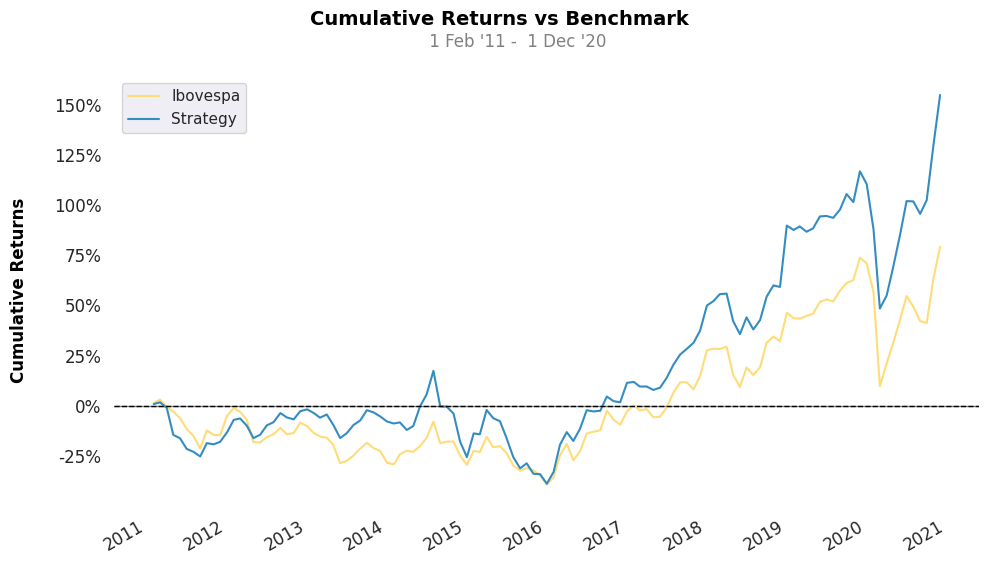

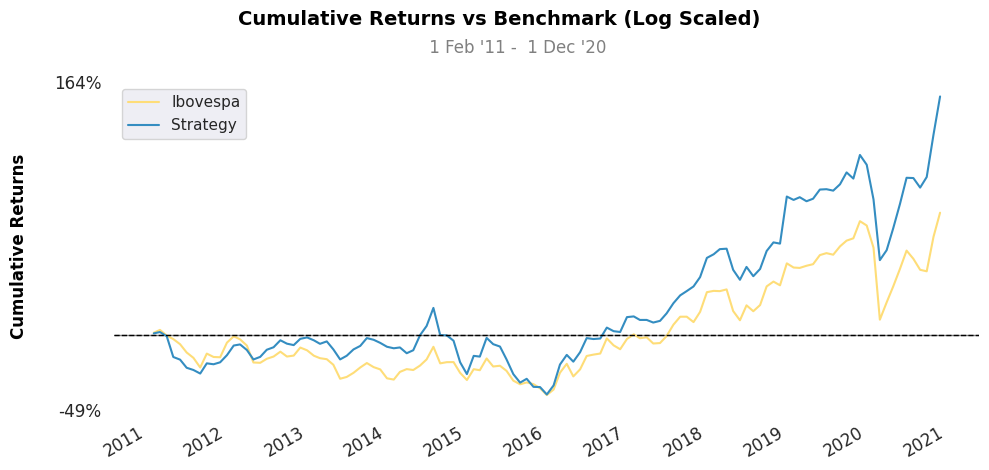

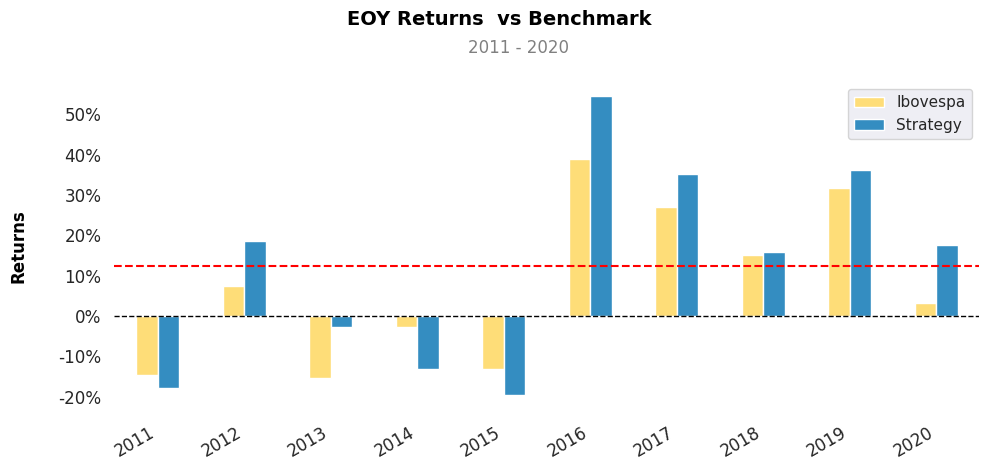

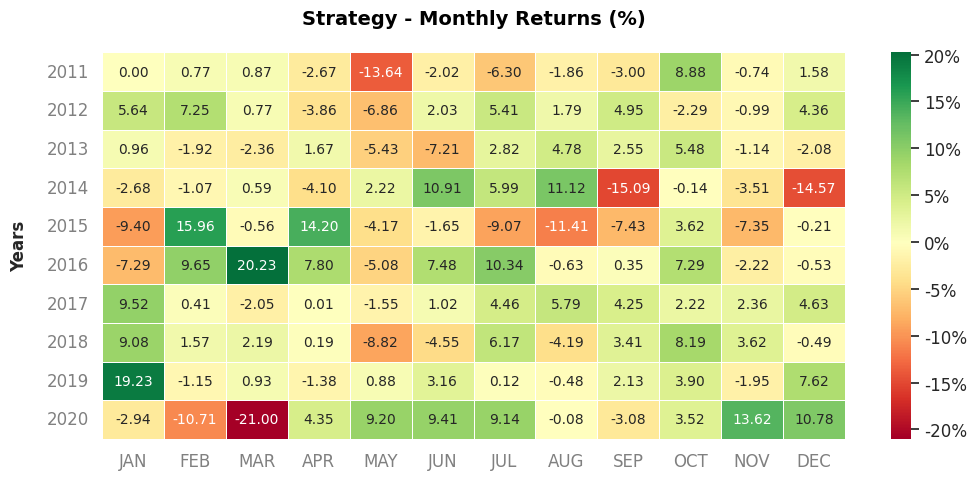

In [52]:
tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

benchmark_br = '^BVSP'
name_benchmark_br = 'Ibovespa'

comparar_estrategia(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,benchmark_br,name_benchmark_br,qtd = 6)

### Comparando com o CDI usando as funções

In [53]:
tickers_br = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

year_br = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
             'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

tabela = Estrategia_Quantamental(tickers_br,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year_br,qtd = 6)

In [54]:
stock = yf.download(tickers=tickers_br, start='2011-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()

df = pd.DataFrame()

for steps in range(len(year_br)):
    array = tabela.loc[year_br[steps]]
    frame1 = pd.DataFrame(array)
    returns_selection = returns.loc[year_br[steps]]
    selected_returns = returns_selection[array]

    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)

df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')
df

[*********************100%***********************]  20 of 20 completed


,Returns
Date,
2011-02,0.007671
2011-03,0.008670
2011-04,-0.026741
2011-05,-0.136440
2011-06,-0.020166
...,...
2020-08,-0.000842
2020-09,-0.030777
2020-10,0.035161


In [55]:
import requests
import pandas as pd

# Definir a URL da API do Banco Central para o CDI
url = 'https://api.bcb.gov.br/dados/serie/bcdata.sgs.1178/dados?formato=json'

# Fazer uma requisição GET para obter os dados do CDI
response = requests.get(url)

# Verificar se a requisição foi bem-sucedida
if response.status_code == 200:
    # Converter os dados da resposta para um DataFrame
    cdi_data = pd.DataFrame(response.json())

    # Converter a coluna de datas para o formato datetime
    cdi_data['data'] = pd.to_datetime(cdi_data['data'], dayfirst=True)

    # Definir a coluna de datas como o índice do DataFrame
    cdi_data = cdi_data.set_index('data')

    # Converter a coluna de valores para o tipo numérico
    cdi_data['valor'] = pd.to_numeric(cdi_data['valor'])/100
    cdi_data['valor'] = (cdi_data['valor'] + 1)**(1/360) - 1

    # Calcular os retornos mensais do CDI
    retorno_acumulado = (1 + cdi_data).cumprod() - 1
    retorno_mensal = retorno_acumulado.resample('M').last().pct_change()
    retorno_mensal = retorno_mensal.loc[year_br[0]:year_br[-1]]
    
    # Formatar o índice para exibir apenas o ano e o mês
    retorno_mensal.index = pd.PeriodIndex(retorno_mensal.index, freq='M')
    
    # Exibir os retornos mensais do CDI
    print(retorno_mensal)
else:
    print('Falha na requisição. Código de status:', response.status_code)


            valor
data             
2011-01  0.006028
2011-02  0.005900
2011-03  0.006434
2011-04  0.005874
2011-05  0.006906
...           ...
2020-08  0.001119
2020-09  0.001099
2020-10  0.001099
2020-11  0.001046
2020-12  0.001151

[120 rows x 1 columns]


Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2011-02-01   2011-02-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          81.93%       152.83%
CAGR﹪                     4.29%        6.73%

Sharpe                     40.71        2.38
Prob. Sharpe Ratio         -            94.75%
Smart Sharpe               32.96        1.93
Sortino                    -            3.79
Smart Sortino              -            3.07
Sortino/√2                 -            2.68
Smart Sortino/√2           -            2.17
Omega                      1.51         1.51

Max Drawdown               -            -47.95%
Longest DD Days            -            -
Volatility (ann.)          3.12%        106.45%
R^2                        0.01         0.01
Information Ratio          0.07         0.07

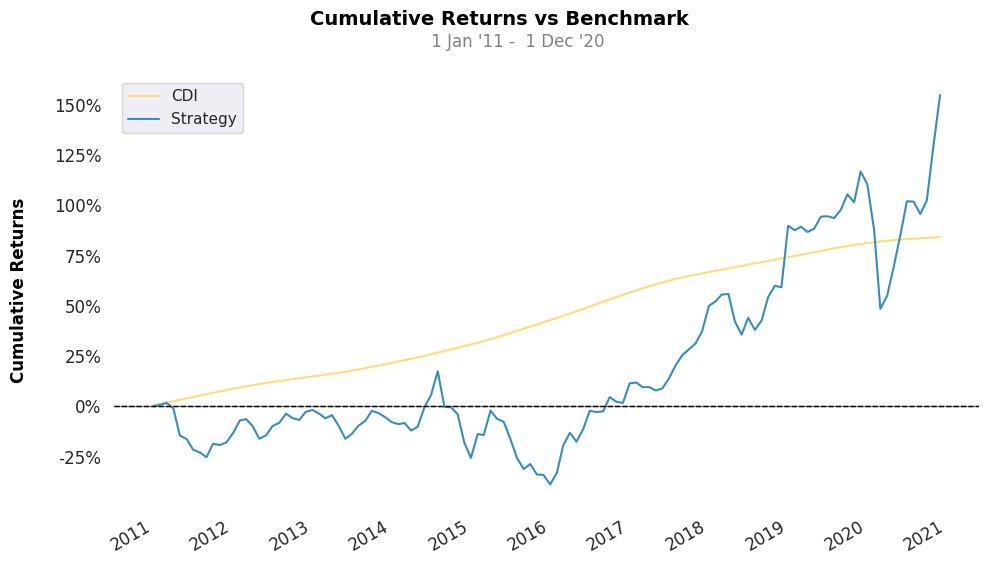

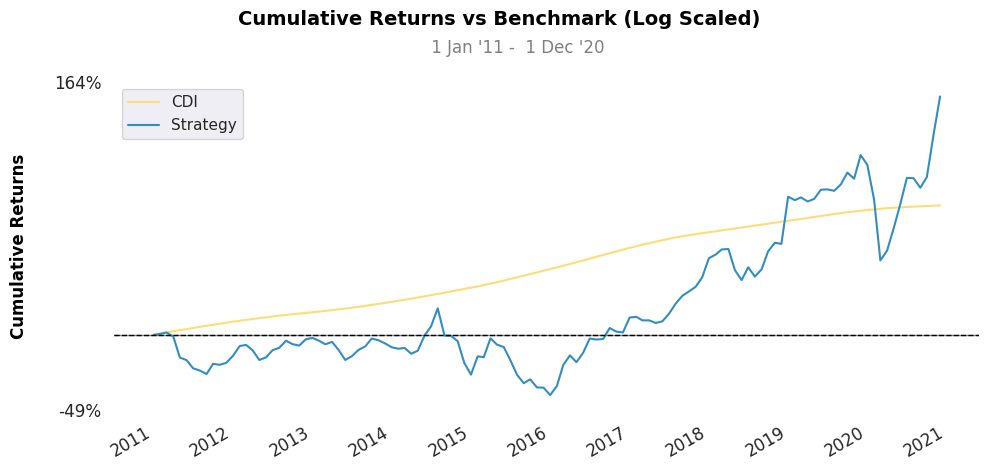

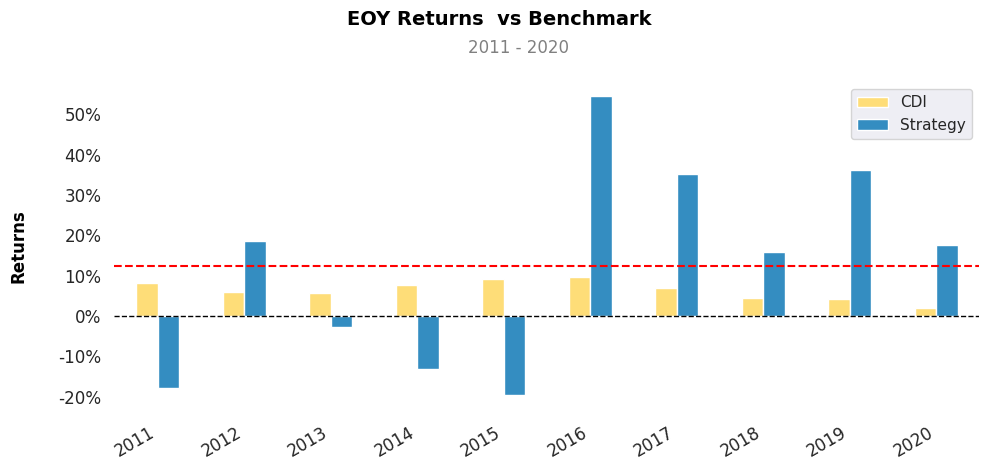

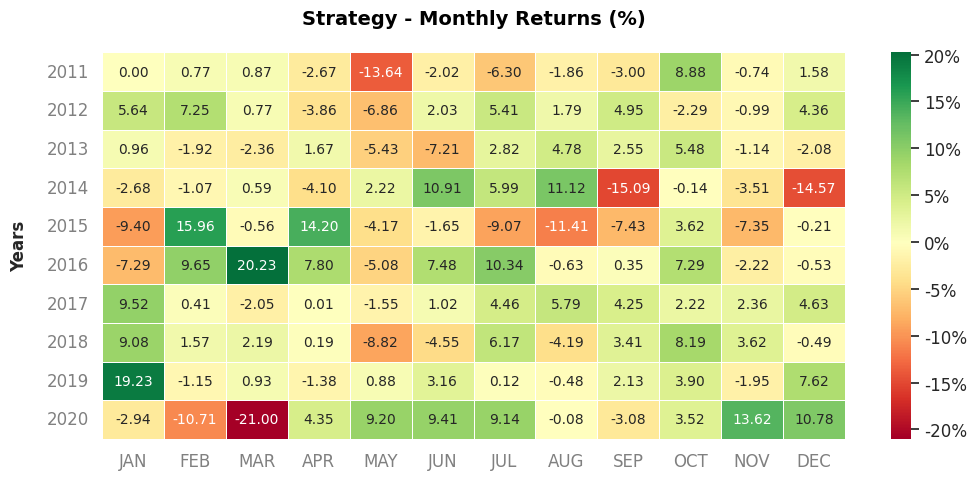

In [56]:
frame_final = pd.concat([df, retorno_mensal], axis=1)
frame_final.columns = ['Strategy', 'CDI']
frame_final.index = frame_final.index.to_timestamp()

print("\033[1mPerformance Metrics\033[0m\n")
qs.reports.metrics(frame_final['Strategy'],frame_final['CDI'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['Strategy'],frame_final['CDI'])
qs.plots.log_returns(frame_final['Strategy'],frame_final['CDI'])
qs.plots.yearly_returns(frame_final['Strategy'],frame_final['CDI'])
qs.plots.monthly_heatmap(frame_final['Strategy'],frame_final['CDI'])

### Testando ajustes mensais

In [35]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

In [15]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2017','2018', '2019', '2020']
year_usado = ['2016','2017','2018', '2019', '2020']

for steps1 in range(len(year_usado)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='quarter')
        table = data.T[ratio]
        table.index = pd.to_datetime(table.index)
        table = table.loc[table.index.year == int(year_usado[steps1])]
        table['Company'] = tickers[steps2]
        Full_table = Full_table.append(table)

Full_table = Full_table.sort_index()
Full_table

,peRatio,priceToSalesRatio,pbRatio,evToSales,debtToEquity,evToFreeCashFlow,debtToAssets,netDebtToEBITDA,Company
2016-01-01,9.412607,9.934258,1.946508,11.467335,0.404117,37.907677,0.218382,4.610439,CSCO
2016-01-01,17.680857,8.961852,2.821833,9.13066,0.466378,148.258273,0.250863,0.84292,AMAT
2016-03-01,-27.000114,26.576887,31.415977,28.076781,3.258815,-69.041588,0.344032,-21.152393,TSLA
2016-03-01,39.330113,12.347441,13.182012,14.620413,3.157772,-672.198992,0.501093,12.839048,PEP
2016-03-01,8.906504,16.300023,9.48219,18.417934,1.703389,38.423282,0.477798,3.291525,GILD
...,...,...,...,...,...,...,...,...,...
2020-12-01,15.529344,34.103283,18.953409,33.775293,0.090971,228.264688,0.05925,-1.621951,AMD
2020-12-01,18.45516,5.379524,2.883197,6.775045,1.088614,130.454758,0.400237,10.074021,PCAR
2020-12-01,19.43157,20.801049,5.31822,20.806444,0.1203,68.836205,0.083763,0.015913,GOOG
2020-12-01,27.167805,39.009729,12.902601,40.285753,0.532863,208.025545,0.22818,2.536619,MSFT


In [16]:
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse

meses_referencia = [1, 4, 7, 10]
def calcular_indice_mensal(data):
    mes_referencia = meses_referencia[data.month // 3] if data.month <= meses_referencia[-1] else 1
    ano = data.year if data.month <= meses_referencia[-1] else data.year + 1
    return pd.to_datetime(f"{ano}-{mes_referencia:02d}-01")

Full_table.index = pd.to_datetime(Full_table.index)

Full_table['index'] = Full_table.index.map(calcular_indice_mensal)

Full_table

,peRatio,priceToSalesRatio,pbRatio,evToSales,debtToEquity,evToFreeCashFlow,debtToAssets,netDebtToEBITDA,Company,index
2016-01-01,9.412607,9.934258,1.946508,11.467335,0.404117,37.907677,0.218382,4.610439,CSCO,2016-01-01
2016-01-01,17.680857,8.961852,2.821833,9.13066,0.466378,148.258273,0.250863,0.84292,AMAT,2016-01-01
2016-03-01,-27.000114,26.576887,31.415977,28.076781,3.258815,-69.041588,0.344032,-21.152393,TSLA,2016-04-01
2016-03-01,39.330113,12.347441,13.182012,14.620413,3.157772,-672.198992,0.501093,12.839048,PEP,2016-04-01
2016-03-01,8.906504,16.300023,9.48219,18.417934,1.703389,38.423282,0.477798,3.291525,GILD,2016-04-01
...,...,...,...,...,...,...,...,...,...,...
2020-12-01,15.529344,34.103283,18.953409,33.775293,0.090971,228.264688,0.05925,-1.621951,AMD,2021-01-01
2020-12-01,18.45516,5.379524,2.883197,6.775045,1.088614,130.454758,0.400237,10.074021,PCAR,2021-01-01
2020-12-01,19.43157,20.801049,5.31822,20.806444,0.1203,68.836205,0.083763,0.015913,GOOG,2021-01-01
2020-12-01,27.167805,39.009729,12.902601,40.285753,0.532863,208.025545,0.22818,2.536619,MSFT,2021-01-01


In [215]:
y = Full_table
y.index = pd.to_datetime(Full_table['index'])
y = y.drop(['Company','index'],axis=1)
t_inv = 1/y
rank = zscore2(t_inv)
rank.insert(0,'Company',Full_table['Company'])
#rank.index = rank.index.strftime('%Y-%m')
rank = rank.sort_index()
rank = rank.loc[year[0]:year[-1]]
rank

,Company,Z-Score
index,,
2017-01-01,PEP,0.986752
2017-01-01,PCAR,1.359299
2017-01-01,GILD,1.185942
2017-01-01,INTC,1.333281
2017-01-01,TXN,0.891570
...,...,...
2020-10-01,GOOG,1.034012
2020-10-01,TXN,0.680950
2020-10-01,TSLA,0.619452


In [14]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]

sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']


# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]

sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [17]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
Final_yr_wise = Final_yr_wise.loc[Final_yr_wise.index.str[:4].isin(year_usado)]

Final_yr_wise.index = pd.to_datetime(Final_yr_wise.index)

Final_yr_wise['index'] = Final_yr_wise.index.map(calcular_indice_mensal)

Final_yr_wise.index = pd.to_datetime(Final_yr_wise['index'])
Final_yr_wise = Final_yr_wise.drop('index',axis=1)
Final_yr_wise = Final_yr_wise.sort_index()
Final_yr_wise = Final_yr_wise.loc[year[0]:year[-1]]

Final_yr_wise

,F-Score-Max,F-Score-Min,G-Score-Max,Company
index,,,,
2017-01-01,-2,-3,0,TSLA
2017-01-01,-2,-1,-4,QCOM
2017-01-01,0,1,-4,MSFT
2017-01-01,0,1,-2,GILD
2017-01-01,0,3,-4,PCAR
...,...,...,...,...
2020-10-01,-2,-1,-6,INTC
2020-10-01,-2,1,-4,GILD
2020-10-01,-2,-3,2,ATVI


In [201]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company
#vc.index = vc.index.strftime('%Y-%m')

vc.head()

,Cumulative-F&G-Score,Company
index,,
2017-01-01,0.535162,TSLA
2017-01-01,0.534403,QCOM
2017-01-01,0.874334,MSFT
2017-01-01,1.059027,GILD
2017-01-01,1.259129,PCAR


In [216]:
# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index'].astype(str) + str('_') + vc_new['Company']

rank_new = rank.reset_index()
rank_new['key'] = rank_new['index'].astype(str) + str('_') + rank_new['Company']

vc_new = vc_new.drop_duplicates(subset='key')
#rank_new = rank_new.drop_duplicates(subset='key')

df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)

dataframe_final

,Company_y,Cumulative-Score
index_x,,
2017-01-01,TSLA,1.103760
2017-01-01,QCOM,1.449618
2017-01-01,MSFT,1.612911
2017-01-01,GILD,2.244969
2017-01-01,PCAR,2.618428
...,...,...
2020-10-01,INTC,1.676391
2020-10-01,GILD,1.606890
2020-10-01,ATVI,1.357129


In [217]:
stock = yf.download(tickers=tickers, start='2016-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  14 of 14 completed


In [218]:
stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()
#returns.index = returns.index.strftime('%Y-%m')
returns = returns.loc[year[0]:year[-1]]
returns.head()

,GILD,MU,AMAT,MSFT,AMD,CSCO,QCOM,GOOG,TSLA,TXN,INTC,ATVI,PEP,PCAR
Date,,,,,,,,,,,,,,
2017-01-01,0.061357,-0.085538,0.113542,0.016545,0.011730,0.032352,0.015164,0.040393,0.099909,0.053365,-0.008124,-0.180521,0.178951,0.035220
2017-02-01,0.057518,0.394407,0.122358,0.112630,-0.027191,0.033158,-0.016839,-0.010364,-0.027789,-0.007428,0.063596,0.057084,-0.007701,0.014297
2017-03-01,0.073992,0.006224,0.104808,-0.011118,-0.036322,0.007714,-0.003591,0.029384,0.232935,0.005837,0.013408,0.015227,0.113245,0.051423
2017-04-01,0.043959,-0.085911,0.047934,0.007988,0.009276,0.092097,0.002218,0.039478,-0.042561,-0.006994,0.012694,-0.062783,0.128530,-0.017130
2017-05-01,0.129771,-0.158647,0.121148,-0.074552,-0.053392,0.065014,-0.001107,0.020158,0.112035,-0.056496,0.031691,0.065687,0.085777,0.041803


In [242]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in range (0,len(sorted(list(set(dataframe_final.index))))):
    step = sorted(list(set(dataframe_final.index)))[steps]
    
    sorted_table = (dataframe_final.loc[step]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)
    
    if step != sorted(list(set(dataframe_final.index)))[-1]:
        step1 = sorted(list(set(dataframe_final.index)))[steps + 1]
        returns_selection = returns.loc[step:step1]
        returns_selection = returns_selection.drop(step1)
    else:
        returns_selection = returns.loc[step:]
    
    selected_returns = returns_selection[array]
    
    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)

    df = df.append(frame)
    df2 = df2.append(frame1)

In [243]:
indice = sorted(list(set(dataframe_final.index)))
comp_index = np.repeat(indice, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

list_comp = pd.DataFrame()
for steps in range(len(indice)):
    f = df2.loc[indice[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = indice
list_comp

,0,1,2,3,4,5
2017-01-01,INTC,GOOG,CSCO,ATVI,AMAT,PCAR
2017-04-01,GOOG,MU,ATVI,MSFT,TSLA,PCAR
2017-07-01,MU,AMAT,MU,GILD,GOOG,PEP
2017-10-01,PCAR,GOOG,PEP,INTC,TXN,GILD
2018-01-01,MU,PCAR,AMD,GOOG,PEP,INTC
2018-04-01,MU,MU,AMD,GOOG,PCAR,ATVI
2018-07-01,MU,GILD,PCAR,QCOM,GOOG,INTC
2018-10-01,GOOG,GILD,INTC,PEP,AMAT,PCAR
2019-01-01,PCAR,ATVI,MU,PEP,GOOG,INTC
2019-04-01,MU,PCAR,GILD,MSFT,CSCO,GOOG


In [244]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

In [245]:
benchmark = yf.download(tickers='NDAQ', start='2016-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [246]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
benchmark_returns = benchmark.pct_change().dropna()
benchmark_returns = benchmark_returns.loc[year[0]:year[-1]]

In [247]:
frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.columns = ['strategy', 'nasdaq']
frame_final.index = frame_final.index.to_timestamp()
frame_final

,strategy,nasdaq
Date,,
2017-01-01,0.005477,0.050953
2017-02-01,0.046688,0.008081
2017-03-01,0.036994,-0.023344
2017-04-01,-0.026820,-0.008351
2017-05-01,0.001081,-0.017715
2017-06-01,-0.006302,0.056763
2017-07-01,0.046010,0.040285
2017-08-01,0.019759,0.013581
2017-09-01,0.009112,0.029053


Performance Metrics

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2017-01-01   2017-01-01
End Period                 2020-12-01   2020-12-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          97.77%       209.95%
CAGR﹪                     12.77%       22.06%

Sharpe                     4.48         6.96
Prob. Sharpe Ratio         96.66%       99.97%
Smart Sharpe               4.35         6.77
Sortino                    7.29         15.65
Smart Sortino              7.08         15.21
Sortino/√2                 5.15         11.07
Smart Sortino/√2           5.01         10.76
Omega                      3.26         3.26

Max Drawdown               -18.47%      -13.44%
Longest DD Days            243          152
Volatility (ann.)          89.21%       92.01%
R^2                        0.22         0.22
Information Ratio          0.16       

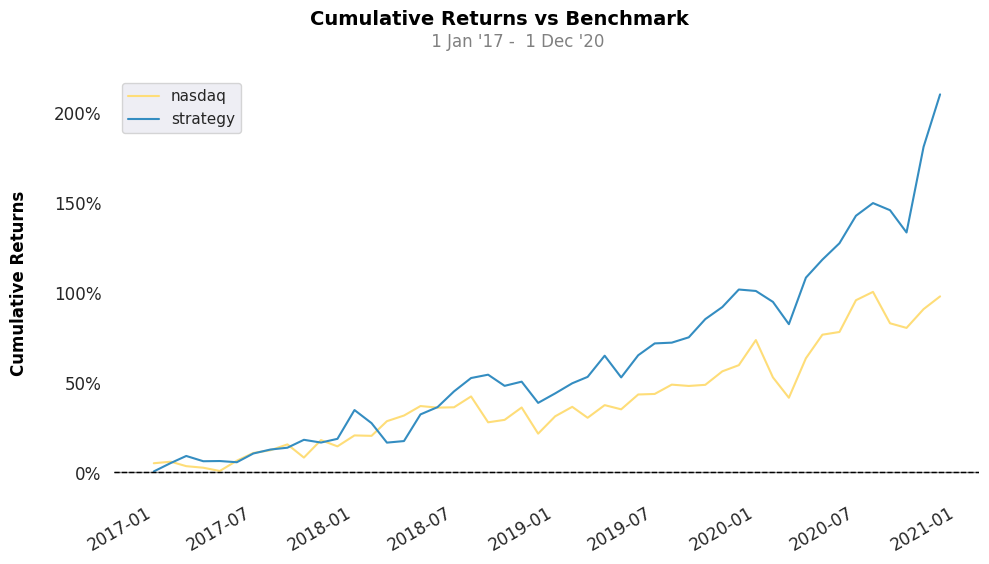

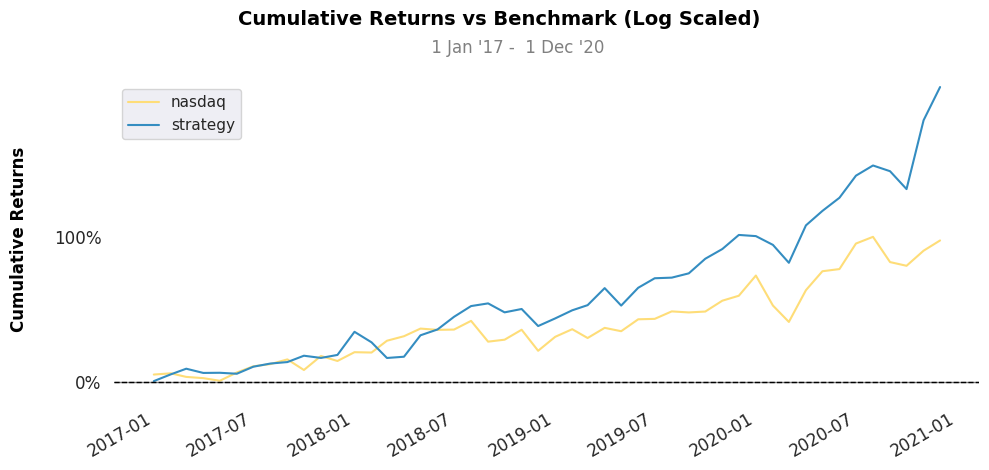

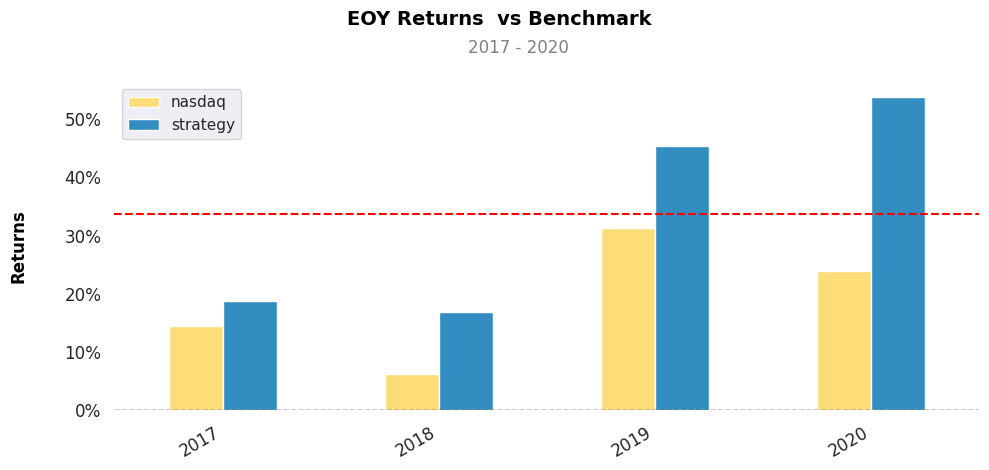

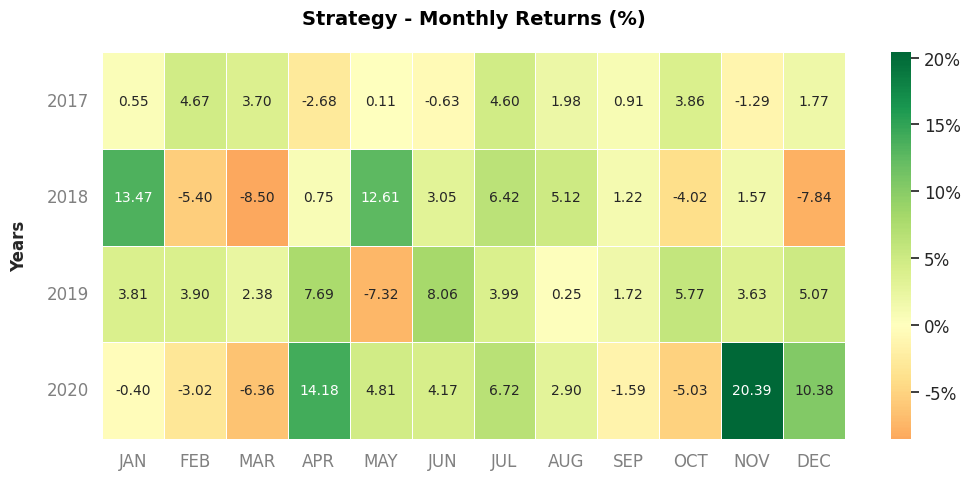

In [248]:
print("\033[1mPerformance Metrics\033[0m\n")
qs.reports.metrics(frame_final['strategy'],frame_final['nasdaq'],mode='full')

print("\n\033[1mStrategy Visualization\033[0m\n")
qs.plots.returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.log_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.yearly_returns(frame_final['strategy'],frame_final['nasdaq'])
qs.plots.monthly_heatmap(frame_final['strategy'],frame_final['nasdaq'])

## Otimizando funções para permitir alterar o ajuste da carteira

In [82]:
def Analise_Fund(tickers,ratio,year,periodo = 'annual'):
    
    Full_table = pd.DataFrame()
    rank = pd.DataFrame()
    year_usado = year.copy()
    year_usado.insert(0,str(int(year[0])-1))
    
    for steps1 in range(len(year_usado)):
        for steps2 in range(len(tickers)):
            p = str(tickers[steps2])
            data = fa.key_metrics(
                ticker=p, api_key=key, period = periodo)
            table = data.T[ratio]
            table.index = pd.to_datetime(table.index)
            table = table.loc[table.index.year == int(year_usado[steps1])]
            table['Company'] = tickers[steps2]
            Full_table = Full_table.append(table)
            
    if periodo != 'annual':

        Full_table.index = pd.to_datetime(Full_table.index)
        Full_table['index'] = Full_table.index.map(calcular_indice_mensal)
        Full_table.index = pd.to_datetime(Full_table['index'])
        
        Full_table = Full_table.drop('index',axis=1)
        
    company = Full_table['Company']
    company =  company.reset_index(drop = True)
    Full_table = Full_table.drop('Company',axis=1)    
    
    y = Full_table.copy()
    t_inv = 1/y
    bv = zscore2(t_inv)
    
    bv = bv.reset_index(drop = True)
    bv.insert(0,'Company',company)
    
    rank = bv
    rank.index = Full_table.index
    rank = rank.sort_index()
    rank = rank.loc[year[0]:year[-1]]

    return rank

def Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = 'annual'):

    percent_fscore_max = pd.DataFrame()
    percent_fscore_min = pd.DataFrame()
    percent_gscore_max = pd.DataFrame()
    vc = pd.DataFrame()
    
    year_usado = year.copy()
    year_usado.insert(0,str(int(year[0])-1))
    
    for steps in range(len(tickers)):
        # Fscore-Max analysis
        p = str(tickers[steps])
        data3 = fa.key_metrics(
            ticker=p, api_key=key, period=periodo)
        tranpose = data3.T[f_score_ratio_max].fillna(0)
        reverse = tranpose.loc[::-1]
        change = reverse.pct_change()
        change = change.assign(Company=p)
        percent_fscore_max = percent_fscore_max.append(change)

        # Fscore-Min analysis
        data4 = fa.key_metrics(
            ticker=p, api_key=key, period=periodo)
        tranpose1 = data4.T[f_score_ratio_min].fillna(0)
        reverse1 = tranpose1.loc[::-1]
        change1 = reverse1.pct_change()
        change1 = change1.assign(Company=p)
        percent_fscore_min = percent_fscore_min.append(change1)

        # Gscore-Max analysis
        data5 = fa.key_metrics(
            ticker=p, api_key=key, period=periodo)
        tranpose2 = data5.T[g_score_ratio_max].fillna(0)
        reverse2 = tranpose2.loc[::-1]
        change2 = reverse2.pct_change()
        change2 = change2.assign(Company=p)
        percent_gscore_max = percent_gscore_max.append(change2)

    # Condition to quantify the performance
    condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
    condition = pd.DataFrame(condition)
    condition.index = percent_fscore_max.index
    condition.columns = percent_fscore_max.columns[:-1]
    
    sum_score = condition.sum(axis=1)
    sum_score = pd.DataFrame(sum_score)
    sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
    sum_score.columns = ['F-Score-Max','Company']

    # Condition to quantify the performance
    condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
    condition2 = pd.DataFrame(condition2)
    condition2.index = percent_fscore_min.index
    condition2.columns = percent_fscore_min.columns[:-1]

    sum_score2 = condition2.sum(axis=1)
    sum_score2 = pd.DataFrame(sum_score2)
    sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
    sum_score2.columns = ['F-Score-Min','Company']

    # Condition to quantify the performance
    condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
    condition3 = pd.DataFrame(condition3)
    condition3.index = percent_gscore_max.index
    condition3.columns = percent_gscore_max.columns[:-1]
    sum_score3 = condition3.sum(axis=1)
    sum_score3 = pd.DataFrame(sum_score3)
    sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
    sum_score3.columns = ['G-Score-Max','Company']
    
    Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
    Final_yr_wise = Final_yr_wise.loc[Final_yr_wise.index.str[:4].isin(year_usado)]
    Final_yr_wise.index = pd.to_datetime(Final_yr_wise.index)
    
    if periodo != 'annual':
        
        Final_yr_wise['index'] = Final_yr_wise.index.map(calcular_indice_mensal)
        Final_yr_wise.index = pd.to_datetime(Final_yr_wise['index'])
        Final_yr_wise = Final_yr_wise.drop('index',axis=1)
        Final_yr_wise = Final_yr_wise.sort_index()
    
    Final_yr_wise = Final_yr_wise.loc[year[0]:year[-1]]
    company = pd.DataFrame(Final_yr_wise['Company'])

    vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
    vc['Company'] = company
    
    return vc

def Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo = 'annual',qtd = 6):
    # Now Joing the two Dataframes and getting a cumulative score of each company for each year
    df = pd.DataFrame()
    
    rank = Analise_Fund(tickers,ratio,year,periodo)
    vc = Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,periodo)
    
    vc_new = vc.reset_index()
    vc_new['index'] = vc_new['index'].astype(str)
    vc_new['key'] = vc_new['index'] + '_' + vc_new['Company']
    
    vc_new = vc_new.drop_duplicates(subset='key')

    rank_new = rank.reset_index()
    rank_new['index'] = rank_new['index'].astype(str)
    rank_new['key'] = rank_new['index'] + '_' + rank_new['Company']
    
    df = vc_new.merge(rank_new, on='key')
    df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
    df.index = df['index_x']
    
    dataframe = df.drop(labels='index_x', axis=1)
    dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
        dataframe['Z-Score'].values
    dataframe_final = dataframe.drop(
        labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
    
    # Ações a serem investidas pela estratégia
    df2 = pd.DataFrame()
    
    for steps in range (0,len(sorted(set(dataframe_final.index)))):
        step = sorted(set(dataframe_final.index))[steps]

        sorted_table = (dataframe_final.loc[step]).sort_values(
            by='Cumulative-Score', ascending=False)
        selection = sorted_table[['Company_y']].head(qtd)
        
        array = np.array(selection['Company_y'])
        frame = pd.DataFrame(array)
        df2 = df2.append(frame)
    
    indice = sorted(list(set(dataframe_final.index)))
    comp_index = np.repeat(indice, qtd)
    df2.index = comp_index
    df2.columns = ['Companies-Invested']

    list_comp = pd.DataFrame()
    for steps in range(len(indice)):
        f = df2.loc[indice[steps]]['Companies-Invested'].T
        mk = np.array(f)
        l = pd.DataFrame(mk).T
        list_comp = list_comp.append(l)

    list_comp.index = indice
    
    return list_comp

def comparar_estrategia(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,ticker_benchmark,name_benchmark,qtd = 6):
    # retorno da estratégia
    estrategia = Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year)
    
    df = pd.DataFrame()
    inicio = year[0] + '-01-01'
    final = year[-1] + '-12-31'
    
    stock = yf.download(tickers=tickers, start=inicio,
                    end=final, interval='1mo')[['Close']]

    stock.index = pd.to_datetime(stock.index)
    stock = (stock.T.drop_duplicates().T).dropna()
    stock.columns = tickers
    returns = stock.pct_change().dropna()
    
    for steps in range(len(year)):
        array = estrategia.loc[year[steps]]
        returns_selection = returns.loc[year[steps]]
        selected_returns = returns_selection[array]

        # Portfólio com pesos iguais
        weight = np.repeat(1/qtd, qtd)
        series = (selected_returns*weight).sum(axis=1)
        frame = pd.DataFrame(series)
        df = df.append(frame)
        
    df.columns = ['Returns']
    df.index = pd.to_datetime(df.index).to_period('M')
    
    # retorno do benchmark
    benchmark = yf.download(tickers=ticker_benchmark, start=inicio,
                        end=final, interval='1mo')[['Close']]
    benchmark = (benchmark.T.drop_duplicates().T).dropna()
    benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
    benchmark_returns = benchmark.pct_change().dropna()
    
    # comparando a estratégia com o benchmark
    frame_final = pd.concat([df, benchmark_returns], axis=1)
    frame_final.columns = ['Strategy', name_benchmark]
    frame_final.index = frame_final.index.to_timestamp()
    
    print("\033[1mPerformance Metrics\033[0m\n")
    qs.reports.metrics(frame_final['Strategy'],frame_final[name_benchmark],mode='full')

    print("\n\033[1mStrategy Visualization\033[0m\n")
    qs.plots.returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.log_returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.yearly_returns(frame_final['Strategy'],frame_final[name_benchmark])
    qs.plots.monthly_heatmap(frame_final['Strategy'],frame_final[name_benchmark])

In [17]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']
ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']
year = ['2017','2018', '2019', '2020']

Analise_Fund(tickers,ratio,year,'quarter')

,Company,Z-Score
index,,
2017-01-01,CSCO,1.168231
2017-01-01,AMAT,1.009450
2017-04-01,AMD,0.554583
2017-04-01,QCOM,0.935448
2017-04-01,GOOG,1.931376
...,...,...
2020-10-01,AMAT,1.241087
2020-10-01,MSFT,0.666853
2020-10-01,TSLA,0.605459


In [15]:
Analise_Fund(tickers,ratio,year,'annual')

,Company,Z-Score
2017-01-01,GILD,1.050819
2017-01-01,MU,1.966729
2017-01-01,AMAT,1.087289
2017-01-01,MSFT,0.758533
2017-01-01,AMD,0.863900
2017-01-01,CSCO,1.246407
2017-01-01,QCOM,1.147446
2017-01-01,GOOG,1.749572
2017-01-01,TSLA,0.502959
2017-01-01,TXN,0.755411


In [13]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year = ['2017','2018', '2019', '2020']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'annual')

,Cumulative-F&G-Score,Company
2017-01-01,1.142199,GILD
2018-01-01,2.417577,GILD
2019-01-01,1.395006,GILD
2020-01-01,0.374512,GILD
2017-01-01,0.672095,MU
2018-01-01,1.616462,MU
2019-01-01,0.620210,MU
2020-01-01,1.064288,MU
2017-01-01,1.239184,AMAT
2018-01-01,0.638653,AMAT


In [16]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

year = ['2017','2018', '2019', '2020']

f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']

Analise_Quant(tickers,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'quarter')

,Cumulative-F&G-Score,Company
index,,
2017-01-01,0.535162,TSLA
2017-01-01,0.534403,QCOM
2017-01-01,0.874334,MSFT
2017-01-01,1.059027,GILD
2017-01-01,1.259129,PCAR
...,...,...
2020-10-01,0.482160,INTC
2020-10-01,0.681018,GILD
2020-10-01,0.600298,ATVI


In [47]:
Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'annual',6)

,0,1,2,3,4,5
2017-01-01,PCAR,MSFT,MU,GOOG,AMAT,GILD
2018-01-01,MU,GILD,PCAR,GOOG,INTC,AMD
2019-01-01,ATVI,MSFT,PCAR,MU,GILD,GOOG
2020-01-01,AMAT,INTC,CSCO,AMD,MSFT,TXN


In [83]:
Estrategia_Quantamental(tickers,ratio,f_score_ratio_min,f_score_ratio_max,g_score_ratio_max,year,'quarter',8)

,0,1,2,3,4,5,6,7
2017-01-01,INTC,GOOG,CSCO,ATVI,AMAT,PCAR,TXN,GILD
2017-04-01,GOOG,MU,ATVI,MSFT,TSLA,PCAR,AMAT,QCOM
2017-07-01,MU,AMAT,MU,GILD,GOOG,PEP,ATVI,PCAR
2017-10-01,PCAR,GOOG,PEP,INTC,TXN,GILD,AMAT,AMD
2018-01-01,MU,PCAR,AMD,GOOG,PEP,INTC,ATVI,AMAT
2018-04-01,MU,MU,AMD,GOOG,PCAR,ATVI,MSFT,INTC
2018-07-01,MU,GILD,PCAR,QCOM,GOOG,INTC,AMD,CSCO
2018-10-01,GOOG,GILD,INTC,PEP,AMAT,PCAR,TXN,TSLA
2019-01-01,PCAR,ATVI,MU,PEP,GOOG,INTC,MU,AMAT
2019-04-01,MU,PCAR,GILD,MSFT,CSCO,GOOG,QCOM,AMAT
